# ECE 232E Project 4: Graph Algorithms

# 1. Stock Market

In [1]:
if (!require("igraph")) install.packages("igraph")
library ("igraph")
if (!require("clevr")) install.packages("clevr")
library ("clevr")

### 1. Return correlation

<div class="alert alert-block alert-success">
<b>Question 1:</b> What are upper and lower bounds on $\rho_{ij}$? Provide a justification for using log-normalized return $(r_{i}(t))$ instead of regular return $(q_{i}(t))$.
</div>

<div class="alert alert-block alert-success">
<b>Answer 1:</b> By observing the numerator and denominator of the given defined correlation function $\rho_{ij}$, we can see the following relation:

$$
\rho_{ij} = 
\frac{⟨r_{i}(t)r_{j}(t)⟩ - ⟨r_{i}(t)⟩⟨r_{j}(t)⟩}{\sqrt{(⟨r_{i}(t)^{2}⟩ - ⟨r_{i}(t)⟩^{2})(⟨r_{j}(t)^{2}⟩ - ⟨r_{j}(t)⟩^{2})}} = 
\frac{COV(r_{i}(t), r_{j}(t))}{\sqrt{VAR(r_{i}(t)) VAR(r_{j}(t))}}
$$

, which resemble the form of standard correlation coefficient $COR(r_{i}(t), r_{j}(t))$. Therefore, the upper bound of $\rho_{ij}$ is +1 and lower bound of $\rho_{ij}$ is -1 since the values of correlation coefficient $COR(r_{i}(t), r_{j}(t))$ can range from -1 to +1. 
<br>
<br>

Justifications for using log-normalized return $(r_{i}(t))$ instead of regular return $(q_{i}(t))$ can be summarized into the followings:

<ul>  
  <li>Comparing to the absolute value, normalized value represents better in terms of showing the fluctuation patterns, whcih is our goal, as the base price value itself of each stock might be different and thus the price increase differently in linear scale, but the change in percentage scale could be the same.</li>
  <li>It helps to constraint the values of the fluctuation within a finite bounds.</li>
  <li>It reduces the effects of outliers and skewness inside the data.</li>
</ul>
</div>

### 2. Constructing correlation graphs

<div class="alert alert-block alert-success">
<b>Question 2:</b> Plot a histogram showing the un-normalized distribution of edge weights.
</div>

In [ ]:
unzip('finance_data.zip')

In [ ]:
path <- "finance_data/data/"
out.file <- ""
file.names <- dir(path, pattern =".csv")
m <- matrix(, nrow = 0, ncol = 765)
sectors.table <- read.table("finance_data/Name_sector.csv", 
                            header=TRUE, sep=",", stringsAsFactors=TRUE)
sectors <- c()
sectors.names <- c()
for(i in 1:length(file.names)){
    file <- read.table(paste("finance_data/data/", file.names[i], sep = ""),
                             header=TRUE, sep=",", stringsAsFactors=FALSE)
    if(length(file$Close)==765){
        m <- rbind(m, matrix(file$Close, nrow=1, ncol=765))
        mystr <- substr(file.names[i], 1, nchar(file.names[i])-4)
        sector <- sectors.table$Sector[which(sectors.table$Symbol == mystr)]
#         print(sector)
#        sectors = c(sectors, as.factor(sector))
        sectors.names <- c(sectors.names, toString(sector))
    }
}
com_num <- length(sectors.names)
data_num <- ncol(m)
sector.set <- as.factor(sectors.names)
sectors.index <- as.numeric(sector.set)
num_sector <- length(unique(sectors.index))
table(sector.set)

sector.set
    Consumer Discretionary           Consumer Staples 
                        84                         36 
                    Energy                 Financials 
                        34                         63 
               Health Care                Industrials 
                        60                         64 
    Information Technology                  Materials 
                        66                         24 
               Real Estate Telecommunication Services 
                        31                          4 
                 Utilities 
                        28 

In [ ]:
# get log-normalized return
log_norm_m <- matrix(0, com_num, data_num-1)
for (i in c(1:com_num)) {
  p <- m[i,]
  q <- c()
  r <- c()
  for (t in c(2:data_num)) {
    q[t-1] <- (p[t] - p[t-1])/p[t-1]
  }
  r <- log(1 + q)
  log_norm_m[i,] <- r 
}

# compute the correlation (rho) and edge weights (w) and store in a file
edge_weight_file <- file("finance_data/edge_weights.txt", "w")
cat("Source", "\t", "Sink", "\t", "Weight", file=edge_weight_file)
for (i in c(1:(dim(log_norm_m)[1]-1))) {
  for (j in c((i+1):dim(log_norm_m)[1])) {
    r_i <- mean(log_norm_m[i,]) 
    r_j <- mean(log_norm_m[j,])
    r_i2 <- log_norm_m[i,]^2
    r_j2 <- log_norm_m[j,]^2
    numerator <- ((mean(log_norm_m[i,]*log_norm_m[j,])) - (r_i*r_j))
    denominator <- (sqrt((mean(r_i2)-(r_i^2))*(mean(r_j2)-(r_j^2))))
    rho_ij <- numerator / denominator
    w_ij <- sqrt(2*(1 - rho_ij))
    cat('\n', sectors.table[i, 1], '\t', sectors.table[j, 1], '\t', 
        w_ij, file=edge_weight_file)
  }
}
close(edge_weight_file)

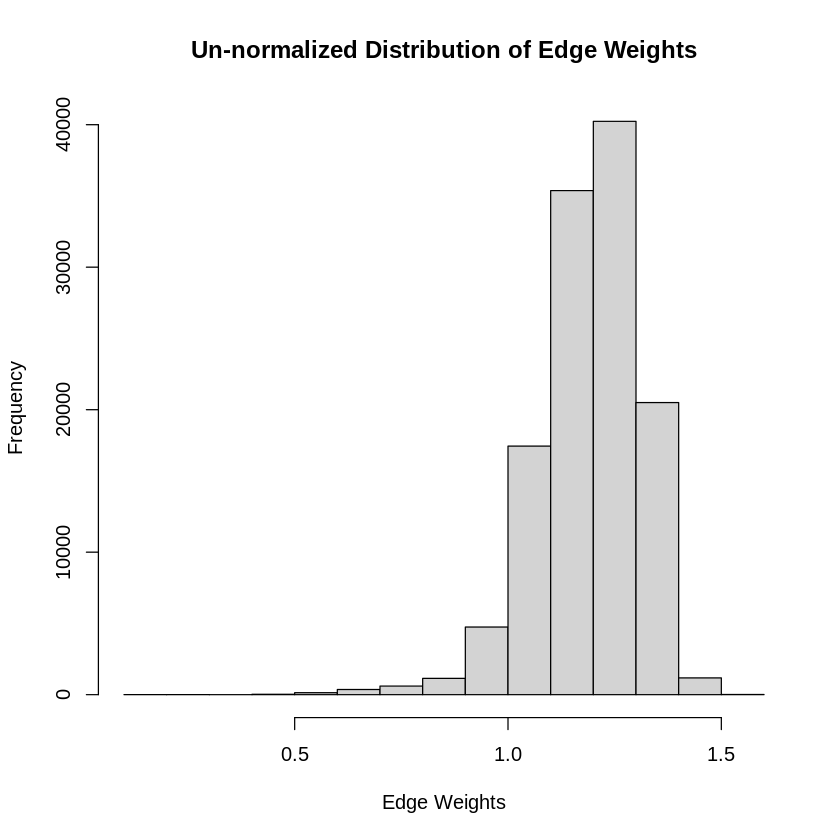

In [ ]:
edge_list <- read.delim("finance_data/edge_weights.txt", header=TRUE)
correlation_graph <- graph.data.frame(edge_list, directed=FALSE)
E(correlation_graph)$weight <- edge_list[,"Weight"]
hist(edge_list[,"Weight"], xlab="Edge Weights", ylab="Frequency",
     main="Un-normalized Distribution of Edge Weights")

<div class="alert alert-block alert-success">
<b>Answer 2:</b> The histogram of the un-normalized distribution of edge weights is shown above.
</div>

### 3. Minimum spanning tree (MST)

<div class="alert alert-block alert-success">
<b>Question 3:</b> Extract the MST of the correlation graph. Each stock can be categorized into a sector, which can be found in Name sector.csv file. Plot the MST and color-code the nodes based on sectors. Do you see any pattern in the MST? The structures that you find in MST are called Vine clusters. Provide a detailed explanation about the pattern you observe.
</div>

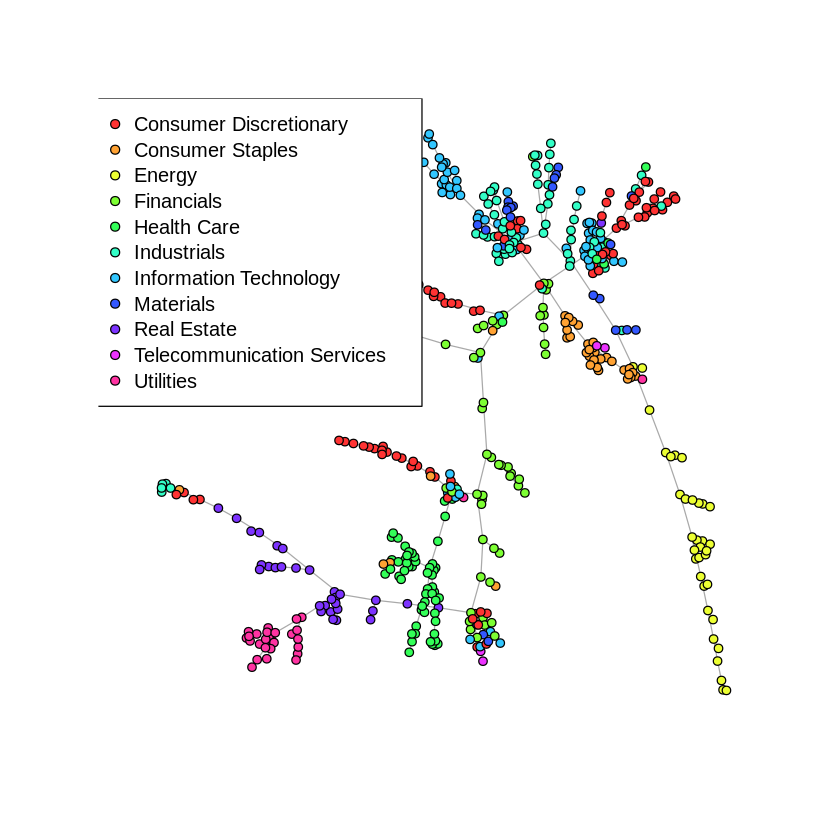

In [ ]:
mst_g <- mst(correlation_graph, algorithm="prim")
colbar <- rainbow(num_sector, s=0.8, v=1)
plot(mst_g, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft', legend=levels(sector.set), pch=21, pt.bg=colbar)

<div class="alert alert-block alert-success">
<b>Answer 3:</b> Based on the correlation graph depicted above, several patterns can be observed. Firstly, stocks within the same sector, represented by the same color, tend to exhibit a tendency to cluster together in the MSP. This is in line with expectations, given their high correlation, resulting in connections with minimal edge weights on the graph. Secondly, stocks belonging to distinct sectors, indicated by different colors, are generally not connected to one another and exhibit significant edge weights. The objective of MST is to establish connections between nodes by prioritizing the lowest cumulative edge weights, which leads to the formation of vine clusters resembling grapes hanging from a central branch. These clusters correspond to different sectors within the stock market. 
</div>

<div class="alert alert-block alert-success">
<b>Question 4:</b> Run a community detection algorithm (for example walktrap) on the MST obtained above. Plot the communities formed. Compute the homogeneity and completeness of the clustering. (you can use the 'clevr' library in r to compute homogeneity and completeness).
</div>

[1] "Number of clusters: 33"
[1] "Homogenity: 0.682645"
[1] "Completeness: 0.479284"


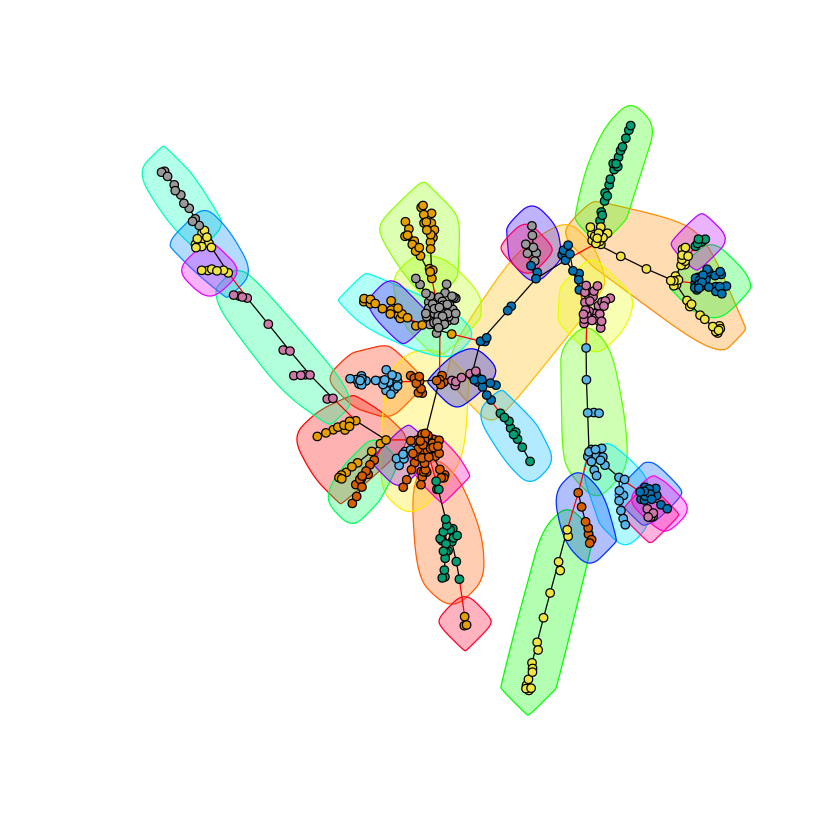

In [ ]:
# cluster
wc_daily <- cluster_walktrap(mst_g) # you can use walktrap.community  
plot(wc_daily, mst_g, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)

# get metrics
true<- c(sectors.index)
pred <- c(wc_daily$membership)

print(sprintf("Number of clusters: %d", length(wc_daily)))
print(sprintf("Homogenity: %f", homogeneity(true, pred)))
print(sprintf("Completeness: %f", completeness(true, pred)))

<div class="alert alert-block alert-success">
<b>Answer 4:</b> The result is shown above. The homogenity is 0.682645 and the completeness is 0.479284.
</div>

### 4. Sector clustering in MST's

<div class="alert alert-block alert-success">
<b>Question 5:</b> Report the value of $\alpha$ for the above two cases and provide an interpretation for the difference.
</div>

In [ ]:
unique_sectors = unique(sectors.index)
num_sector <- length(unique(sectors.index))

# get S_i: sector of node i
S_i <- c()
for (i in c(1:length(unique_sectors))) {
  S_i[i] <- length(which(sectors.index==unique_sectors[i]))
}

# compute two different P
P1 <- c()
P2 <- c()
for (v in c(1:vcount(mst_g))) {
  neighbors <- neighbors(mst_g, v)
  N_i <- length(neighbors)
  # find Q_i: set of neighbors of node i that belong to the same sector as node i
  Q_i <- 0
  for(i in neighbors){
    if(sectors.index[v]==sectors.index[i])
      Q_i <- Q_i + 1
  }
  P1[v] <- Q_i / N_i
  P2[v] <- S_i[which(unique_sectors==sectors.index[v])]/vcount(mst_g)
}

# compute two different alpha
alpha1 <- sum(P1)/vcount(mst_g)
alpha2 <- sum(P2)/vcount(mst_g)

print(sprintf("Values of first alpha based on Qi, Ni: %f", alpha1))
print(sprintf("Values of second alpha based on Si, V: %f", alpha2))

[1] "Values of first alpha based on Qi, Ni: 0.828930"
[1] "Values of second alpha based on Si, V: 0.114188"


<div class="alert alert-block alert-success">
<b>Answer 5:</b> $\alpha_{1}$ is around 0.83 and $\alpha_{2}$ is around 0.11. One can see that $\alpha_{1}$ is much higher than $\alpha_{2}$, meaning that the first technique based on $P(v_{i} \in S_{i}) = \frac{|Q_{i}|}{|N_{i}|}$ is way better compared to the second technique. This is expected as the first technique takes the MST vine cluster structures into consideration and exploits local connectivity among neighboring nodes, whereas the second technique simply utilizes the entire data by considering all the nodes of the same sector, which ignores the local spatial connections. Therefore, it results in lower value.
</div>

### 5. Correlation graphs for weekly data

<div class="alert alert-block alert-success">
<b>Question 6:</b> Repeat questions 2,3,4,5 on the WEEKLY data
</div>

In [ ]:
file <- read.table(paste("finance_data/data/",file.names[1],sep = ""),
                   header=TRUE, sep=",", stringsAsFactors=FALSE)
Date_data <- file$Date
weekdays_data <- weekdays(as.Date(Date_data)) # this gives weekday name 

# select data where week day is monday 
weekly_m_m <- m[, which(weekdays_data=='Monday')] 
weekly_data_num <- ncol(weekly_m_m)

# get log-normalized return
ln_weekly_m <- matrix(0, com_num, weekly_data_num-1)
for (i in c(1:com_num)) {
  p <- weekly_m_m[i,]
  q <- c()
  r <- c()
  for (t in c(2:weekly_data_num)) {
    q[t-1] <- (p[t] - p[t-1])/p[t-1]
  }
  r <- log(1 + q)
  ln_weekly_m[i,] <- r 
}

# compute the correlation (rho) and edge weights (w) and store in a file
edge_weight_file <- file("finance_data/weekly_edge_weights.txt", "w")
cat("Source", "\t", "Sink", "\t", "Weight", file=edge_weight_file)
for (i in c(1:(dim(ln_weekly_m)[1]-1))) {
  for (j in c((i+1):dim(ln_weekly_m)[1])) {
    r_i <- mean(ln_weekly_m[i,]) 
    r_j <- mean(ln_weekly_m[j,])
    r_i2 <- ln_weekly_m[i,]^2
    r_j2 <- ln_weekly_m[j,]^2
    numerator <- ((mean(ln_weekly_m[i,]*ln_weekly_m[j,])) - (r_i*r_j))
    denominator <- (sqrt((mean(r_i2)-(r_i^2))*(mean(r_j2)-(r_j^2))))
    rho_ij <- numerator / denominator
    w_ij <- sqrt(2*(1 - rho_ij))
    cat('\n', sectors.table[i, 1], '\t', sectors.table[j, 1], '\t', 
        w_ij, file=edge_weight_file)
  }
}
close(edge_weight_file)

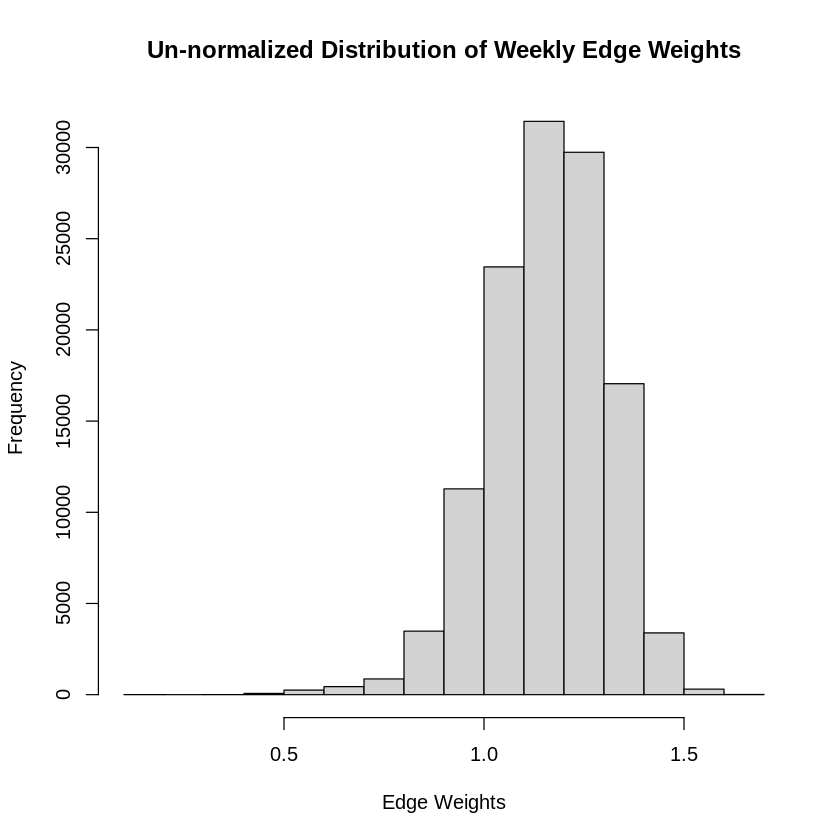

In [ ]:
weekly_edge_list <- read.delim("finance_data/weekly_edge_weights.txt", header=TRUE)
weekly_correlation_graph <- graph.data.frame(weekly_edge_list, directed=FALSE)
E(weekly_correlation_graph)$weight <- weekly_edge_list[,"Weight"]
hist(weekly_edge_list[,"Weight"], xlab="Edge Weights", ylab="Frequency",
     main="Un-normalized Distribution of Weekly Edge Weights")

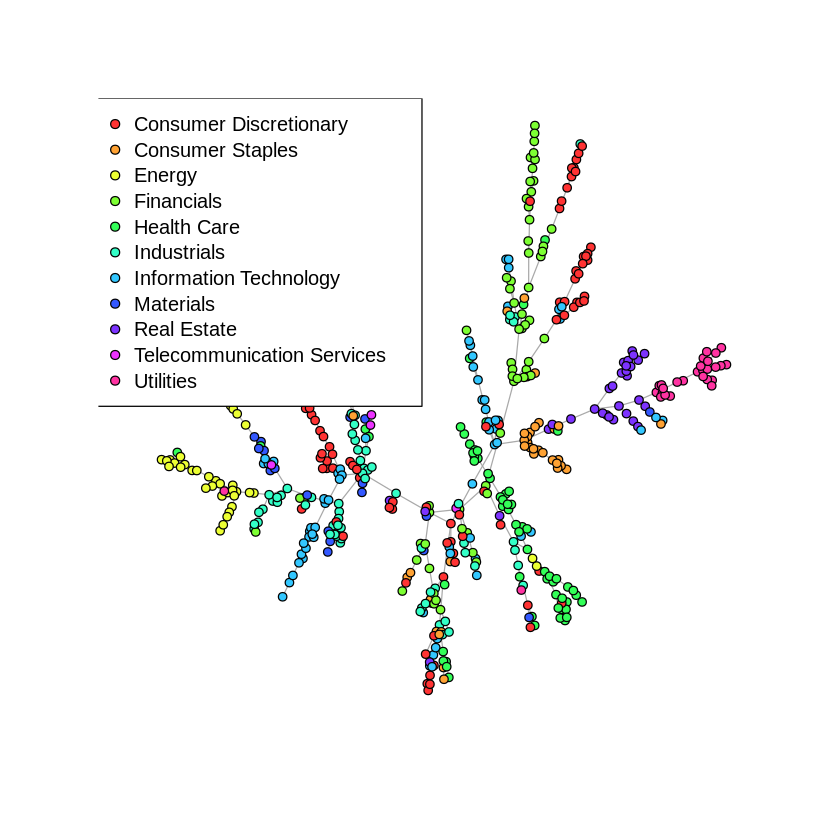

In [ ]:
mst_week_m <- mst(weekly_correlation_graph, algorithm="prim")
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_week_m, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] "Number of clusters: 42"
[1] "Homogenity: 0.582007"
[1] "Completeness: 0.390771"


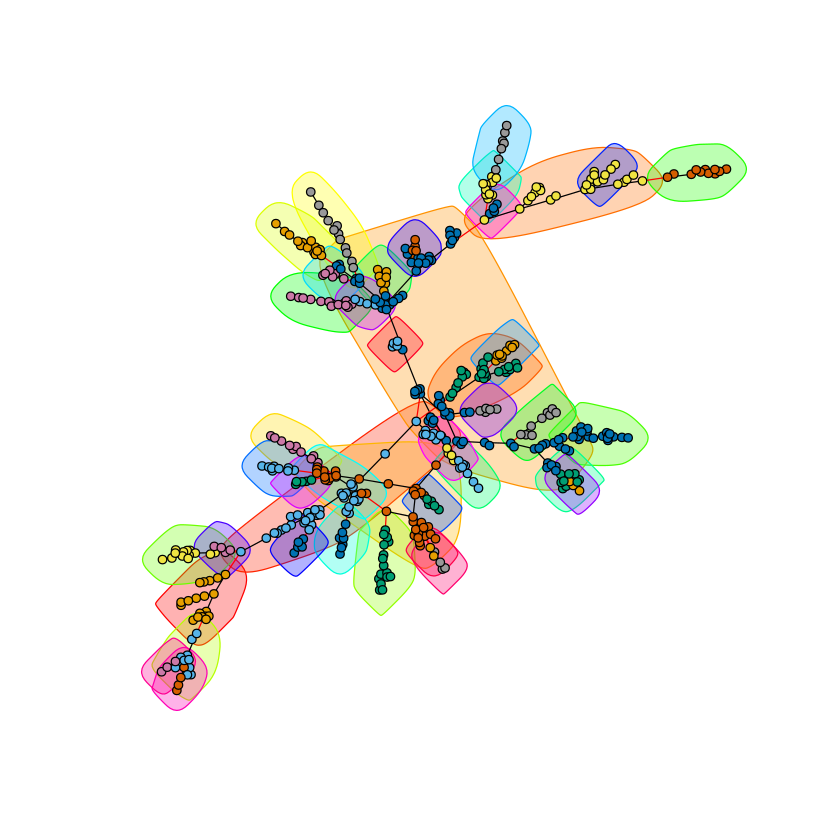

In [ ]:
# cluster
wc_weekly <- cluster_walktrap(mst_week_m) # you can use walktrap.community  
plot(wc_weekly, mst_week_m, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)

# get metrics
true<- c(sectors.index)
pred <- c(wc_weekly$membership)

print(sprintf("Number of clusters: %d", length(wc_weekly)))
print(sprintf("Homogenity: %f", homogeneity(true, pred)))
print(sprintf("Completeness: %f", completeness(true, pred)))

In [ ]:
unique_sectors = unique(sectors.index)
num_sector <- length(unique(sectors.index))

# get S_i: sector of node i
S_i <- c()
for (i in c(1:length(unique_sectors))) {
  S_i[i] <- length(which(sectors.index==unique_sectors[i]))
}

# compute two different P
P1 <- c()
P2 <- c()
for (v in c(1:vcount(mst_week_m))) {
  neighbors <- neighbors(mst_week_m, v)
  N_i <- length(neighbors)
  # find Q_i: set of neighbors of node i that belong to the same sector as node i
  Q_i <- 0
  for(i in neighbors){
    if(sectors.index[v]==sectors.index[i])
      Q_i <- Q_i + 1
  }
  P1[v] <- Q_i / N_i
  P2[v] <- S_i[which(unique_sectors==sectors.index[v])]/vcount(mst_week_m)
}

# compute two different alpha
alpha1_week_m <- sum(P1)/vcount(mst_week_m)
alpha2_week_m <- sum(P2)/vcount(mst_week_m)

print("Based on weekly data:")
print(sprintf("- Values of first alpha based on Qi, Ni: %f", alpha1_week_m))
print(sprintf("- Values of second alpha based on Si, V: %f", alpha2_week_m))

[1] "Based on weekly data:"
[1] "- Values of first alpha based on Qi, Ni: 0.742970"
[1] "- Values of second alpha based on Si, V: 0.114188"


<div class="alert alert-block alert-success">
<b>Answer 6:</b> The results based on weekly data are shown above. Comparing to daily data, one can notice that the total number of clusters increase from 33 to 42 and the value of homogenity and completeness both reduce around 0.1. This means that this time the stocks are not that clearly clustered as before, which can be observed in the correlation graph of MST. Stocks within the same sector, marked in the same color, do not group clearly together as the correlation graph based on daily data. In fact, one can see some mix of nodes from each sector in the neighboring of some nodes, which indicates that the stocks are no longer that high correlated with respect to the weekly data. Therefore, the $\alpha_{1}$ value, which relates to the local connectivity among neighboring nodes, also reduces from 0.83 to 0.75. The $\alpha_{2}$ value, on the other hand, does not change at all since it always takes all nodes into consideration.
</div>

### 6. Correlation graphs for MONTHLY data

<div class="alert alert-block alert-success">
<b>Question 7:</b> Repeat questions 2,3,4,5 on the MONTHLY data.
</div>

In [ ]:
file <- read.table(paste("finance_data/data/",file.names[1],sep = ""),
                   header=TRUE, sep=",", stringsAsFactors=FALSE)
Date_data <- file$Date
dates_num <- as.numeric(format(as.Date(Date_data), "%d")) # format(#write code here)

# select data where date is 15 
monthly_15_m <- m[, which(dates_num==15)] 
monthly_data_num <- ncol(monthly_15_m)

# get log-normalized return
ln_monthly_m <- matrix(0, com_num, monthly_data_num-1)
for (i in c(1:com_num)) {
  p <- monthly_15_m[i,]
  q <- c()
  r <- c()
  for (t in c(2:monthly_data_num)) {
    q[t-1] <- (p[t] - p[t-1])/p[t-1]
  }
  r <- log(1 + q)
  ln_monthly_m[i,] <- r 
}

# compute the correlation (rho) and edge weights (w) and store in a file
edge_weight_file <- file("finance_data/monthly_edge_weights.txt", "w")
cat("Source", "\t", "Sink", "\t", "Weight", file=edge_weight_file)
for (i in c(1:(dim(ln_monthly_m)[1]-1))) {
  for (j in c((i+1):dim(ln_monthly_m)[1])) {
    r_i <- mean(ln_monthly_m[i,]) 
    r_j <- mean(ln_monthly_m[j,])
    r_i2 <- ln_monthly_m[i,]^2
    r_j2 <- ln_monthly_m[j,]^2
    numerator <- ((mean(ln_monthly_m[i,]*ln_monthly_m[j,])) - (r_i*r_j))
    denominator <- (sqrt((mean(r_i2)-(r_i^2))*(mean(r_j2)-(r_j^2))))
    rho_ij <- numerator / denominator
    w_ij <- sqrt(2*(1 - rho_ij))
    cat('\n', sectors.table[i, 1], '\t', sectors.table[j, 1], '\t', 
        w_ij, file=edge_weight_file)
  }
}
close(edge_weight_file)

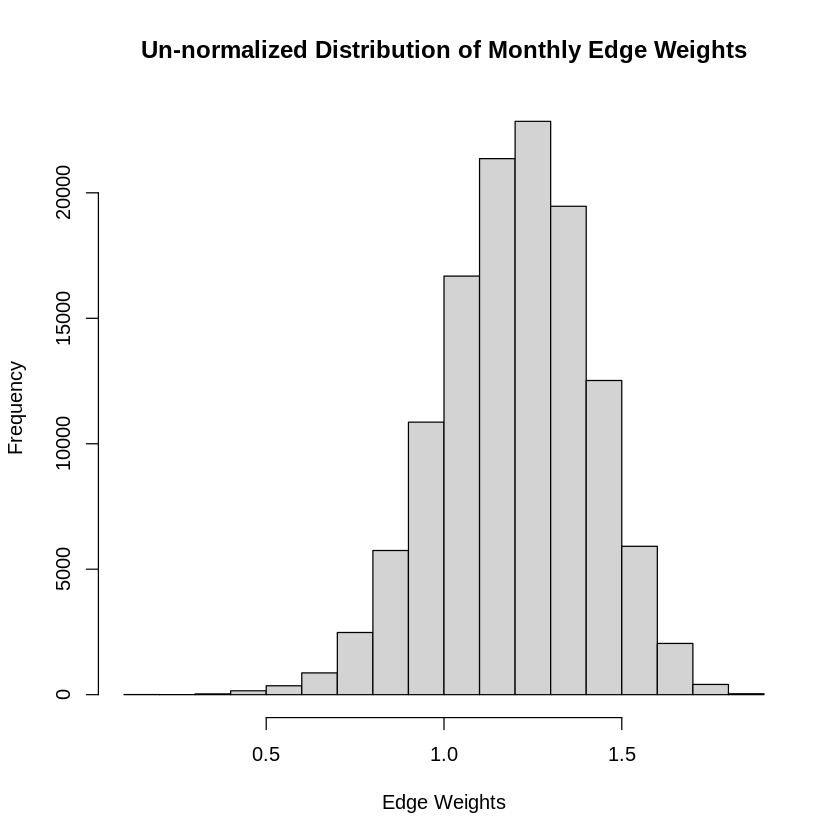

In [ ]:
monthly_edge_list <- read.delim("finance_data/monthly_edge_weights.txt", header=TRUE)
monthly_correlation_graph <- graph.data.frame(monthly_edge_list, directed=FALSE)
E(monthly_correlation_graph)$weight <- monthly_edge_list[,"Weight"]
hist(monthly_edge_list[,"Weight"], xlab="Edge Weights", ylab="Frequency",
     main="Un-normalized Distribution of Monthly Edge Weights")

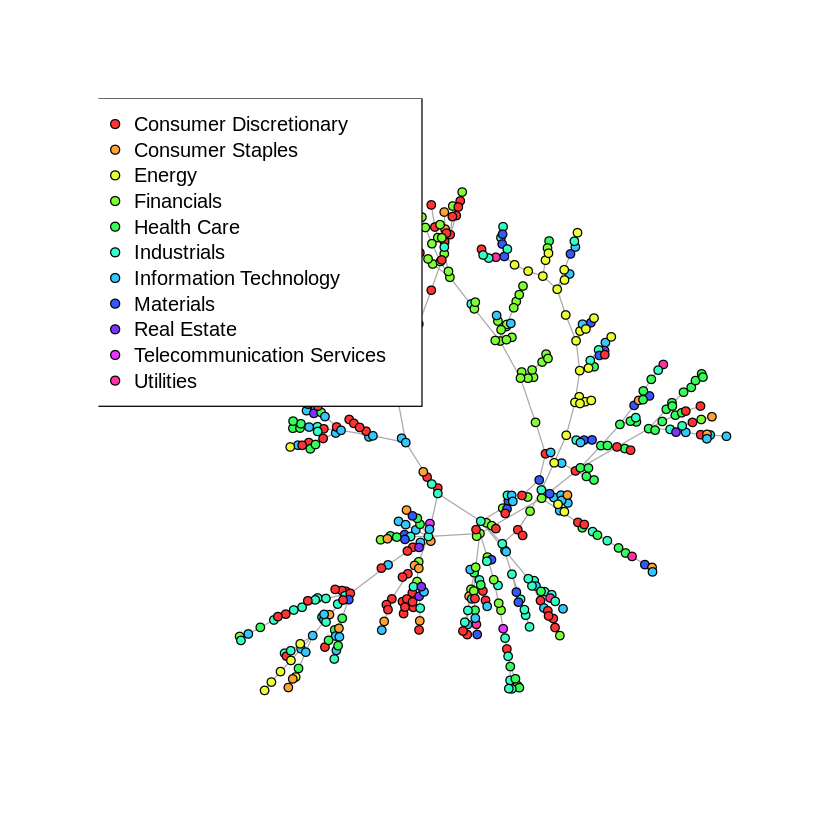

In [ ]:
mst_month_15 <- mst(monthly_correlation_graph, algorithm="prim")
colbar <- rainbow(num_sector,s = 0.8, v = 1)
plot(mst_month_15, vertex.size=3, vertex.label=NA, vertex.color=colbar[sectors.index])
legend('topleft',legend=levels(sector.set),pch=21, pt.bg=colbar)

[1] "Number of clusters: 74"
[1] "Homogenity: 0.509509"
[1] "Completeness: 0.282338"


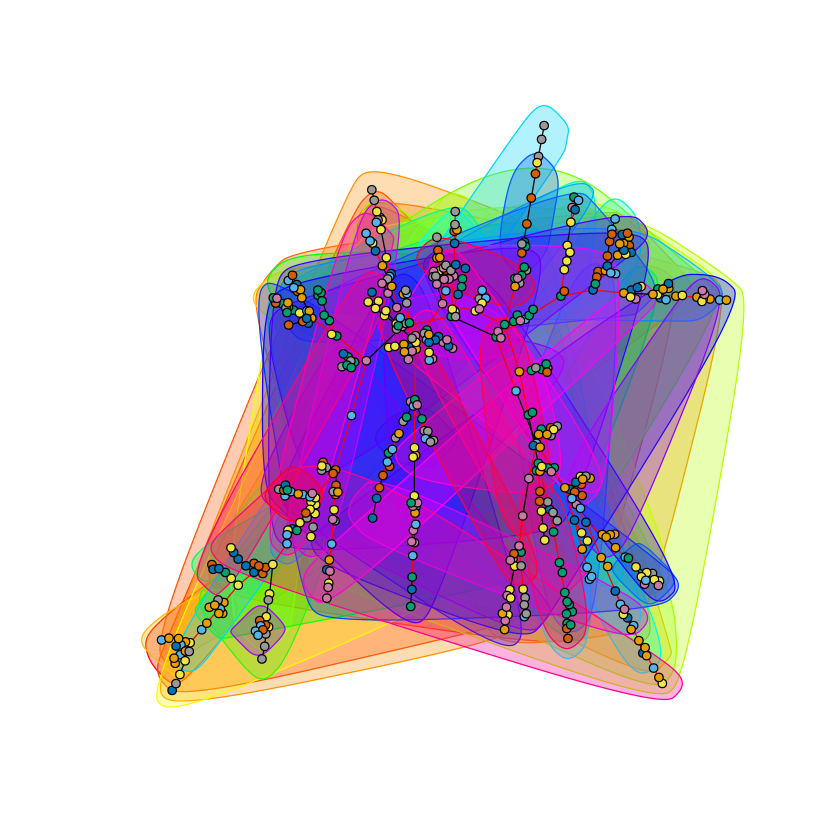

In [ ]:
# cluster
wc_monthly <- cluster_walktrap(mst_month_15) # you can use walktrap.community  
plot(wc_monthly, mst_week_m, vertex.size=3, vertex.label=NA, vertex.color=sectors.index)

# get metrics
true<- c(sectors.index)
pred <- c(wc_monthly$membership)

print(sprintf("Number of clusters: %d", length(wc_monthly)))
print(sprintf("Homogenity: %f", homogeneity(true, pred)))
print(sprintf("Completeness: %f", completeness(true, pred)))

In [ ]:
unique_sectors = unique(sectors.index)
num_sector <- length(unique(sectors.index))

# get S_i: sector of node i
S_i <- c()
for (i in c(1:length(unique_sectors))) {
  S_i[i] <- length(which(sectors.index==unique_sectors[i]))
}

# compute two different P
P1 <- c()
P2 <- c()
for (v in c(1:vcount(mst_month_15))) {
  neighbors <- neighbors(mst_month_15, v)
  N_i <- length(neighbors)
  # find Q_i: set of neighbors of node i that belong to the same sector as node i
  Q_i <- 0
  for(i in neighbors){
    if(sectors.index[v]==sectors.index[i])
      Q_i <- Q_i + 1
  }
  P1[v] <- Q_i / N_i
  P2[v] <- S_i[which(unique_sectors==sectors.index[v])]/vcount(mst_month_15)
}

# compute two different alpha
alpha1_month_m <- sum(P1)/vcount(mst_month_15)
alpha2_month_m <- sum(P2)/vcount(mst_month_15)

print("Based on monthly data:")
print(sprintf("- Values of first alpha based on Qi, Ni: %f", alpha1_month_m))
print(sprintf("- Values of second alpha based on Si, V: %f", alpha2_month_m))

[1] "Based on monthly data:"
[1] "- Values of first alpha based on Qi, Ni: 0.483468"
[1] "- Values of second alpha based on Si, V: 0.114188"


<div class="alert alert-block alert-success">
<b>Answer 7:</b> The results based on monthly data are shown above. Similar results as in Q6 are yielded. The overall performance based on monthly data decreases. For instance, the homogenity and completeness both reduce around 0.18, meaning a lower clearity among different sectors in the correlation graph, and thus more number of clusters is needed to cluster, i.e. 74 clusters, which is even more than double compared to daily data. Moreover, the $\alpha_{1}$ value also reduce to only 0.48. The main reason for this performance reduction is due to the lack of the data or the reduction of the data size. Since daily data have way more data available for a node compared to the monthly data, it's expected that the graph algorithm could perform better on daily data.
</div>

<div class="alert alert-block alert-success">
<b>Question 8:</b> Compare and analyze all the results of daily data vs weekly data vs monthly data. What trends do you find? What changes? What remains similar? Give reason for your observations. Which granularity gives the best results when predicting the sector of an unknown stock and why?
</div>

<div class="alert alert-block alert-success">
<b>Answer 8:</b> By summing up and analyzing all of the results shown above, one can observe a trend that the overall performance as well as the clustering is better with the daily data, which gives the most sufficient and detailed information regarding the fluctuation of the stock price. Reducing the input data to only weekly data or monthly data will harm the results. In other words, when the time-scale is extended, stocks belonging to the same sector experience a decrease in their correlation. As a result, the edge weights among these stocks in the correlation graph tend to increase, despite them being part of the same node. This will cause difficulty to correctly assign a sector to an unknown stock, which one can see from the decreasing trend in $\alpha_{1}$ value based on daily data to monthly data. The only thing that stays the same is the $\alpha_{2}$ value since it only takes the sectors from all stocks into consideration and doesn't really consider the price fluctuation. Overall, daily data with the first technique to calculate the $\alpha$ gives the best results when predicting the sector of an unknown stock because it provide sufficient information to generate a clear correlation graph and takes the local spatial connectivity into consideration.
</div>